# ANALISIS SENTIMEN LEMBAGA SURVEI PADA PEMILIHAN PRESIDEN 2024 MENGGUNAKAN SUPPORT VECTOR MACHINE

oleh: Alisya Rahmawanti

In [1]:
# Installing package emoji, sastrawi dan nltk
!pip install emoji sastrawi nltk wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.7 MB/s eta 0:00:00


In [2]:
# Import library
# Data handling
import pandas as pd
import numpy as np

# Visualisasi
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text processing
import re
import string
import emoji
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Import Data
df = pd.read_excel('/content/data_tiga_lembaga.xlsx')

df = df[['full_text', 'ls','date','engagement']].dropna()

df.head()


full_text           ls  \
0  Hasil Pemilu 2024 Akan Segera Diumumkan Ini Di...  Poltracking   
1  Lembaga bayaran qc Dan media geng gemoy lg ara...  Poltracking   
2  Kaykanya QC poltracking ya yg hampir presisi. ...  Poltracking   
3  @OmpungGuru @sukmawijaya91 @ReflyHZ Survey tel...  Poltracking   
4  @esipede Mgk krn jumlah paslon kali ini lbh ba...  Poltracking   

                 date  engagement  
0 2024-03-19 13:02:12           0  
1 2024-03-19 03:02:30           0  
2 2024-03-15 21:23:18           0  
3 2024-03-13 15:37:33           2  
4 2024-03-13 10:53:08           1

In [4]:
len(df)

2083

In [5]:
# Filtering data tidak layak
def filter_tweet(text):
    if not isinstance(text, str):
        return False
    if len(text.split()) < 3:
        return False
    return True

df = df[df['full_text'].apply(filter_tweet)]
df = df.drop_duplicates(subset='full_text')
df.reset_index(drop=True, inplace=True)

In [63]:
# Data Layak
df['is_layak'] = True

# Data Tidak Layak
# NaN
df.loc[df['full_text'].isna(), 'is_layak'] = False
# Data < 3 kata
df.loc[
    df['full_text'].str.split().str.len() < 3,
    'is_layak'
] = False
# Data yg setelah preprocessing jadi kosong
df.loc[
    df['clean_text'].str.strip() == '',
    'is_layak'
] = False

# Dipisahkan
df_layak = df[df['is_layak'] == True]
df_tidak_layak = df[df['is_layak'] == False]

In [64]:
df_layak[['full_text']]

full_text
0     Hasil Pemilu 2024 Akan Segera Diumumkan Ini Di...
1     Lembaga bayaran qc Dan media geng gemoy lg ara...
2     Kaykanya QC poltracking ya yg hampir presisi. ...
3     @OmpungGuru @sukmawijaya91 @ReflyHZ Survey tel...
4     @esipede Mgk krn jumlah paslon kali ini lbh ba...
...                                                 ...
1930  Beda Hasil Sementara Quick Count Pilpres 2024 ...
1931  2024 Indonesia Quick Count Lembaga Survei Indo...
1932  Namun sejumlah lembaga survei mengeluarkan has...
1933   Semua penghitungan semua lembaga survei..menu...
1934  Capres Nomor Urut 2 Prabowo Subianto menyampai...

[1934 rows x 1 columns]

In [65]:
df_tidak_layak[['full_text']]

full_text
533  18 tahun lebih 3 bulan 19 hari

In [66]:
# Load lexicon untuk labelling
def load_word_list(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        words = file.read().splitlines()
    return set(words)

positive_words = load_word_list('/content/positive.tsv')
negative_words = load_word_list('/content/negative.tsv')

print("Jumlah kata positif:", len(positive_words))
print("Jumlah kata negatif:", len(negative_words))

Jumlah kata positif: 3609
Jumlah kata negatif: 6606


In [10]:
# Score untuk labelling
def sentiment_score_inset(text, pos_words, neg_words):
    score = 0
    for word in text.split():
        if word in pos_words:
            score += 1
        elif word in neg_words:
            score -= 1
    return score

In [11]:
# Light Preprocessing
def light_preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [12]:
# Konversi skor untuk labelling
def sentiment_label(score):
    if score > 0:
        return 'positif'
    elif score < 0:
        return 'negatif'
    else:
        return 'netral'

In [13]:
# Terapkan pada dataset
df['text_for_label'] = df['full_text'].apply(light_preprocess)

df['sentiment_score'] = df['text_for_label'].apply(
    lambda x: sentiment_score_inset(x, positive_words, negative_words)
)

df['label'] = df['sentiment_score'].apply(sentiment_label)

In [14]:
# Cek hasil labelling
df[['full_text', 'sentiment_score', 'label', 'ls']]

full_text  sentiment_score  \
0     Hasil Pemilu 2024 Akan Segera Diumumkan Ini Di...                3   
1     Lembaga bayaran qc Dan media geng gemoy lg ara...               -2   
2     Kaykanya QC poltracking ya yg hampir presisi. ...                1   
3     @OmpungGuru @sukmawijaya91 @ReflyHZ Survey tel...               -2   
4     @esipede Mgk krn jumlah paslon kali ini lbh ba...                2   
...                                                 ...              ...   
1930  Beda Hasil Sementara Quick Count Pilpres 2024 ...               -2   
1931  2024 Indonesia Quick Count Lembaga Survei Indo...                0   
1932  Namun sejumlah lembaga survei mengeluarkan has...               -1   
1933   Semua penghitungan semua lembaga survei..menu...               -1   
1934  Capres Nomor Urut 2 Prabowo Subianto menyampai...                3   

        label           ls  
0     positif  Poltracking  
1     negatif  Poltracking  
2     positif  Poltracking  
3     negatif  Poltracking  
4     positif  Poltracking  
...       ...          ...  
1930  negatif          LSI  
1931   netral          LSI  
1932  negatif          LSI  
1933  negatif          LSI  
1934  positif          LSI  

[1935 rows x 4 columns]

In [15]:
# Download data hasil labelling
subset_df = df[['full_text', 'sentiment_score', 'label']]

subset_df.to_excel('data_sentimen.xlsx', index=False)

from google.colab import files
files.download('data_sentimen.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Distribusi Label (Cek imbalance data)
label_counts = df['label'].value_counts()
label_percentage = df['label'].value_counts(normalize=True) * 100

label_counts, label_percentage


(label
 positif    997
 negatif    579
 netral     359
 Name: count, dtype: int64,
 label
 positif    51.524548
 negatif    29.922481
 netral     18.552972
 Name: proportion, dtype: float64)

In [17]:
# diff < 20 → seimbang
# 20 ≤ diff < 40 → cukup imbalance
# diff ≥ 40 → imbalance serius

max_pct = label_percentage.max()
min_pct = label_percentage.min()
diff = max_pct - min_pct

diff

32.97157622739019

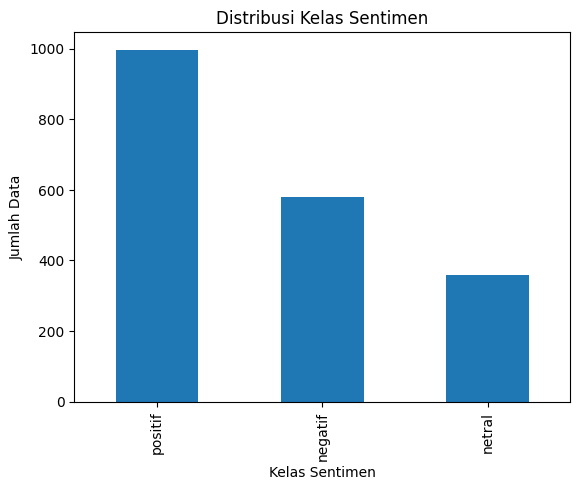

In [18]:
# Plot Label
label_counts.plot(kind='bar')
plt.title('Distribusi Kelas Sentimen')
plt.xlabel('Kelas Sentimen')
plt.ylabel('Jumlah Data')
plt.show()

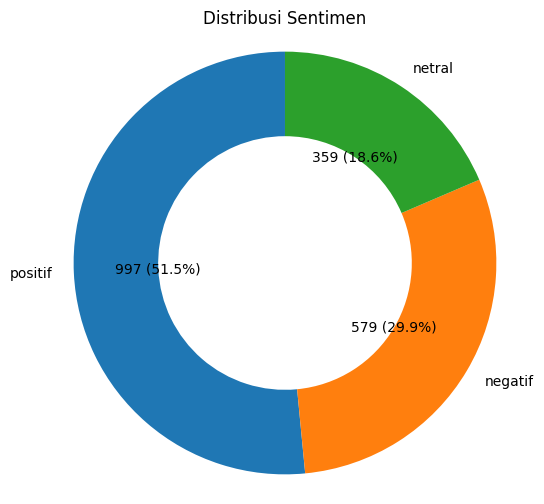

In [19]:
# Plot Label
labels = label_counts.index
sizes = label_counts.values
total = sizes.sum()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val} ({pct:.1f}%)'
    return my_autopct

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),
    startangle=90,
    wedgeprops={'width': 0.4}
)
plt.title('Distribusi Sentimen')
plt.axis('equal')
plt.show()

In [20]:
sentimen_lembaga = (
    df
    .groupby(['ls', 'label'])
    .size()
    .reset_index(name='jumlah')
)

sentimen_lembaga

ls    label  jumlah
0         CSIS  negatif      95
1         CSIS   netral      59
2         CSIS  positif     182
3          LSI  negatif     389
4          LSI   netral     264
5          LSI  positif     666
6  Poltracking  negatif      95
7  Poltracking   netral      36
8  Poltracking  positif     149

In [21]:
def plot_donut(data, lembaga_name):
    labels = data['label']
    sizes = data['jumlah']

    plt.figure(figsize=(5, 5))
    plt.pie(
        sizes,
        labels=labels,
        autopct=make_autopct(sizes),
        startangle=90,
        wedgeprops={'width': 0.4}
    )
    plt.title(f'Distribusi Sentimen – {lembaga_name}')
    plt.axis('equal')
    plt.show()

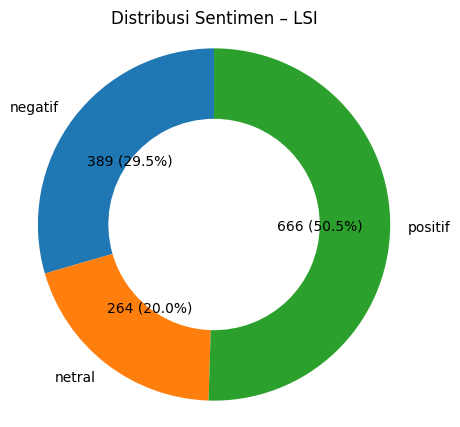

In [22]:
plot_donut(
    sentimen_lembaga[sentimen_lembaga['ls'] == 'LSI'],
    'LSI'
)

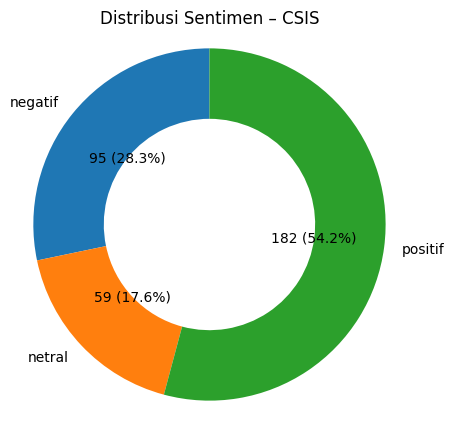

In [23]:
plot_donut(
    sentimen_lembaga[sentimen_lembaga['ls'] == 'CSIS'],
    'CSIS'
)

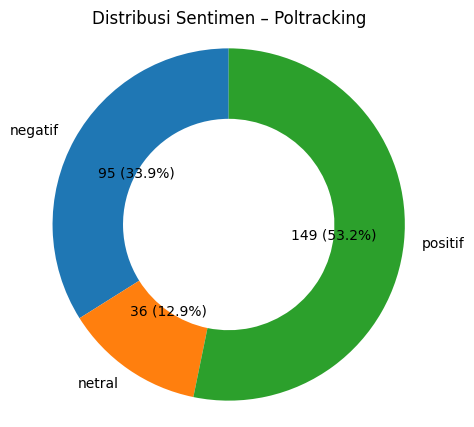

In [24]:
plot_donut(
    sentimen_lembaga[sentimen_lembaga['ls'] == 'Poltracking'],
    'Poltracking'
)

In [25]:
stop_words = set(stopwords.words('indonesian'))

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def load_acronyms(filepath):
    acronym_dict = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('=')
            if len(parts) == 2:
                acronym_dict[parts[0]] = parts[1]
    return acronym_dict

normalization_dict = load_acronyms('/content/acronym_lower.txt')

def load_kbba_dict(filepath):
    kbba_dict = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('=')
            if len(parts) == 2:
                kbba_dict[parts[0]] = parts[1]
    return kbba_dict

kbba_dict = load_kbba_dict('/content/kbba.txt')

In [26]:
len(normalization_dict)

4065

In [27]:
len(kbba_dict)

1292

In [28]:
# Text Preprocessing
def preprocess(text):
    text = text.lower()                                   # Case Folding
    text = re.sub(r'http\S+|www\S+', '', text)            # Cleansing
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'(.)\1{2,}', r'\1', text)              # Expressive Lengthening

    words = text.split()                                  # Tokenizing
    words = [normalization_dict.get(w, w) for w in words] # Spell Normalization
    words = [kbba_dict.get(w, w) for w in words]          # Slang Handling
    words = [w for w in words if w not in stop_words]     # Stopword Removal
    words = [stemmer.stem(w) for w in words]              # Stemming

    return ' '.join(words)

df['clean_text'] = df['full_text'].apply(preprocess)

In [29]:
df[['full_text', 'clean_text']]

full_text  \
0     Hasil Pemilu 2024 Akan Segera Diumumkan Ini Di...   
1     Lembaga bayaran qc Dan media geng gemoy lg ara...   
2     Kaykanya QC poltracking ya yg hampir presisi. ...   
3     @OmpungGuru @sukmawijaya91 @ReflyHZ Survey tel...   
4     @esipede Mgk krn jumlah paslon kali ini lbh ba...   
...                                                 ...   
1930  Beda Hasil Sementara Quick Count Pilpres 2024 ...   
1931  2024 Indonesia Quick Count Lembaga Survei Indo...   
1932  Namun sejumlah lembaga survei mengeluarkan has...   
1933   Semua penghitungan semua lembaga survei..menu...   
1934  Capres Nomor Urut 2 Prabowo Subianto menyampai...   

                                             clean_text  
0     hasil pilih umum umum ikat notaris indonesia d...  
1     lembaga bayar quick count media geng gemoy ara...  
2          kaykanya quick count poltracking iya presisi  
3     survey telepon responden orang nyurvey lembaga...  
4     mgk pasang calon kali ikat notaris indonesia l...  
...                                                 ...  
1930  beda hasil quick count milu presiden lembaga s...  
1931  indonesia quick count lembaga survei indonesia...  
1932  lembaga survei keluar hasil quick count prabow...  
1933  hitung lembaga surveimenunjukkan angka menang ...  
1934  capres nomor urut prabowo subianto pidato sele...  

[1935 rows x 2 columns]

In [30]:
subset_df = df[['full_text', 'clean_text']]

subset_df.to_excel('data_full_clean.xlsx', index=False)

from google.colab import files
files.download('data_full_clean.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

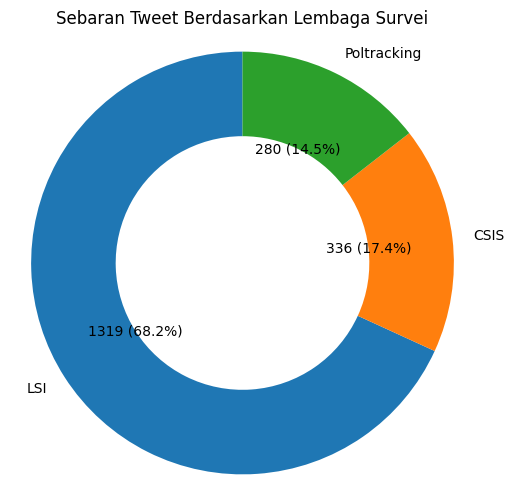

In [31]:
# Plot Lembaga Survei

lembaga_counts = df['ls'].value_counts()

labels = lembaga_counts.index
sizes = lembaga_counts.values
total = sizes.sum()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val} ({pct:.1f}%)'
    return my_autopct

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),
    startangle=90,
    wedgeprops={'width': 0.4}
)

plt.title('Sebaran Tweet Berdasarkan Lembaga Survei')
plt.axis('equal')
plt.show()

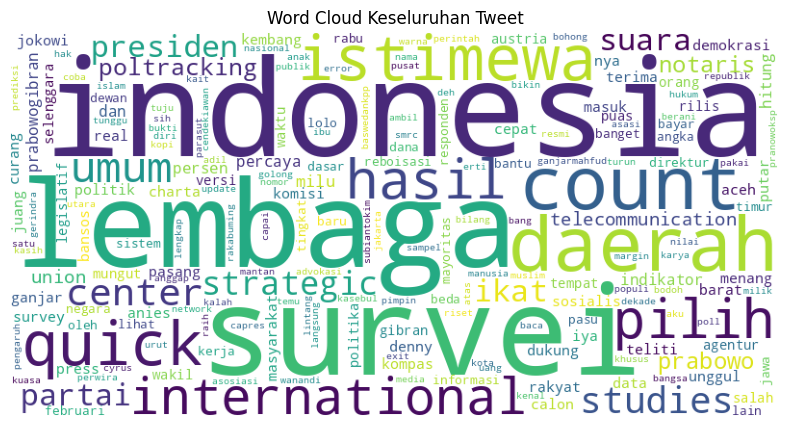

In [32]:
# Ilustrasi word cloud semua lembaga survei
all_text = ' '.join(df['clean_text'].astype(str))

wc_all = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    collocations=False
).generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wc_all)
plt.axis('off')
plt.title('Word Cloud Keseluruhan Tweet')
plt.show()

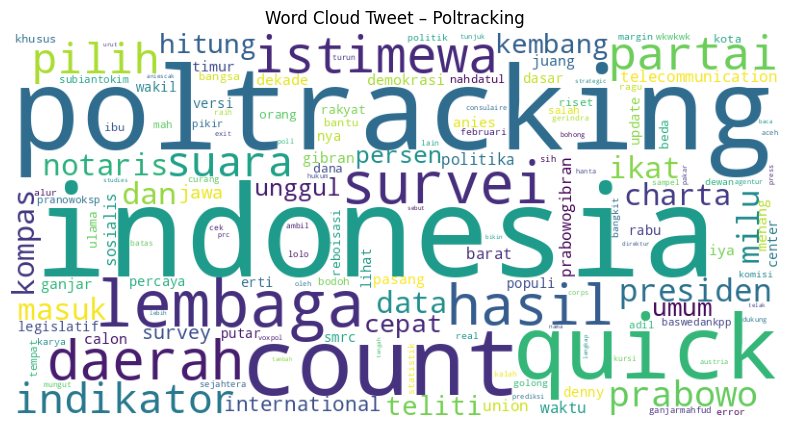

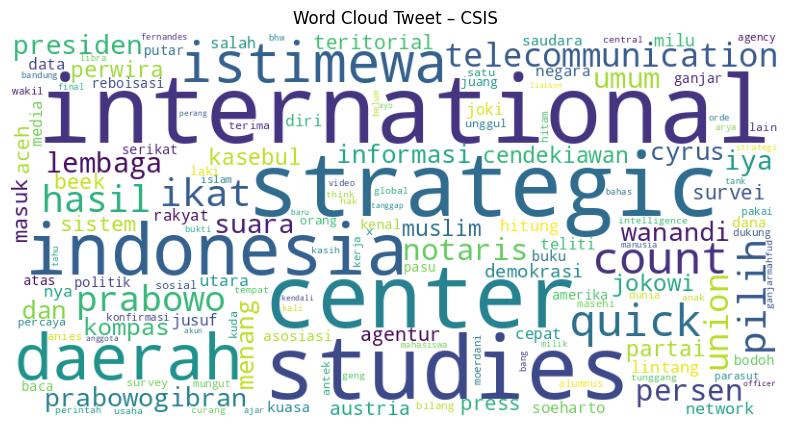

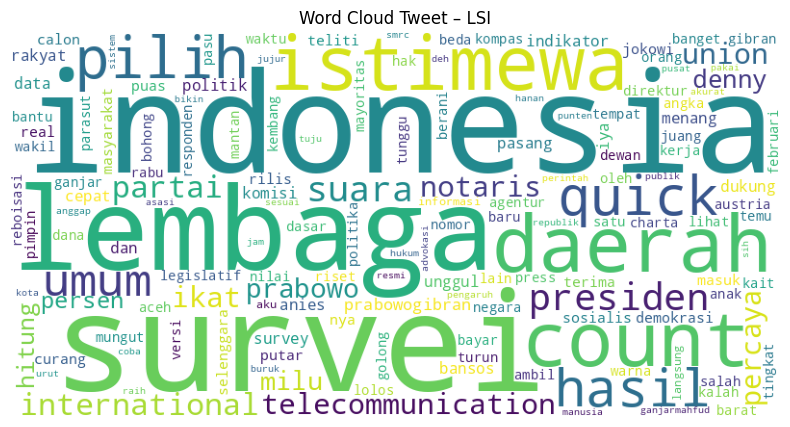

In [33]:
# Ilustrasi word cloud masing-masing lembaga survei
for lembaga in df['ls'].unique():
    text_lembaga = ' '.join(
        df[df['ls'] == lembaga]['clean_text'].astype(str)
    )

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=150,
        collocations=False
    ).generate(text_lembaga)

    plt.figure(figsize=(10,5))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(f'Word Cloud Tweet – {lembaga}')
    plt.show()

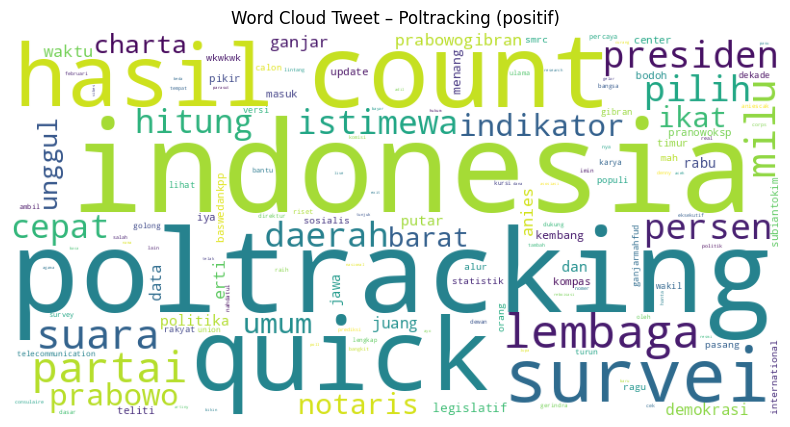

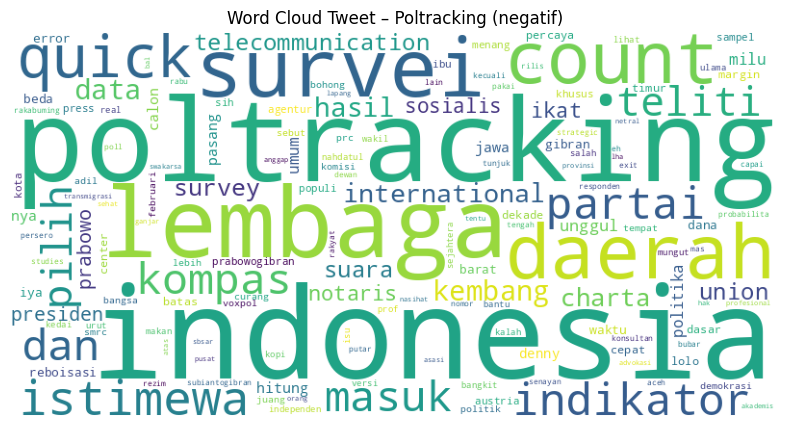

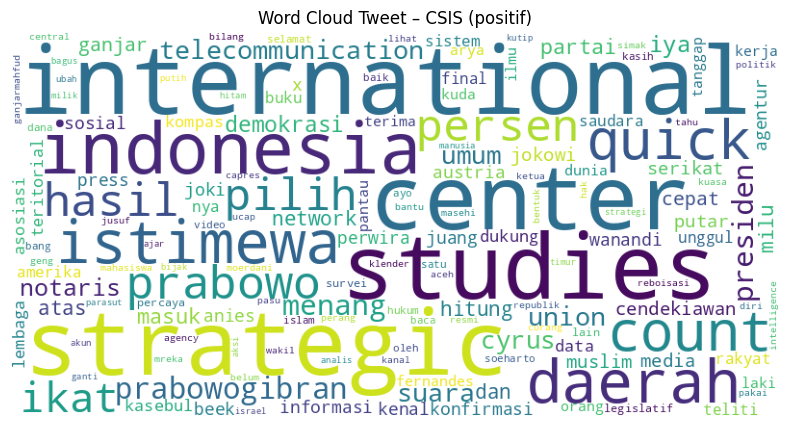

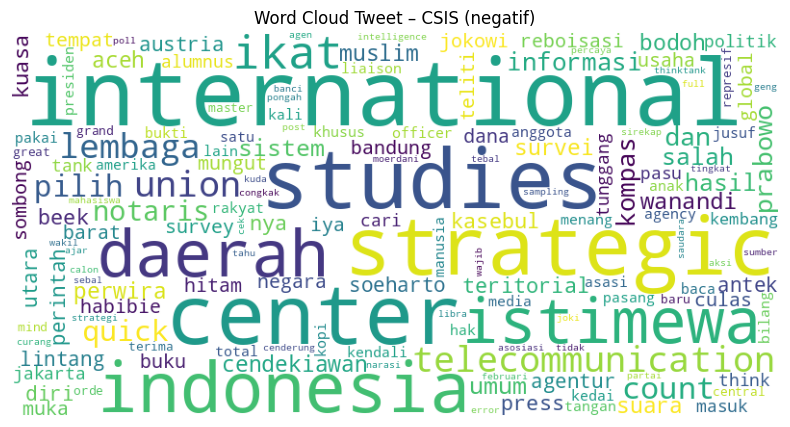

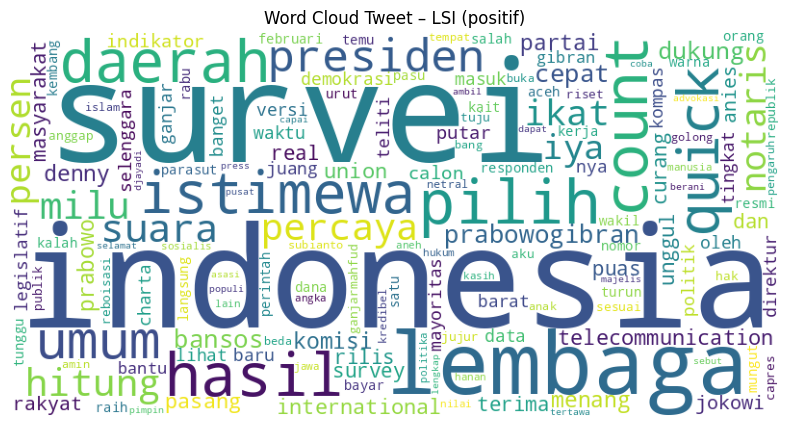

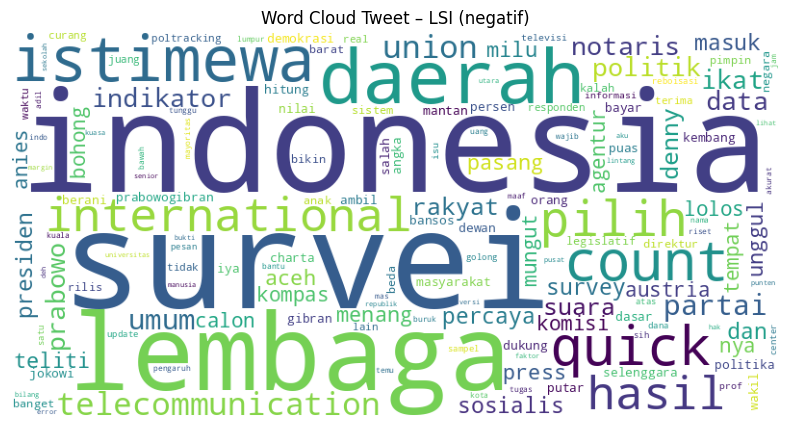

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sentiments = ['positif', 'negatif']

for lembaga in df['ls'].unique():
    for sentimen in sentiments:

        df_subset = df[
            (df['ls'] == lembaga) &
            (df['label'] == sentimen)
        ]

        # gabungkan teks
        text_lembaga = ' '.join(
            df_subset['clean_text']
            .dropna()
            .astype(str)
        )

        # skip kalau kosong
        if text_lembaga.strip() == '':
            continue

        wc = WordCloud(
            width=800,
            height=400,
            background_color='white',
            max_words=150,
            collocations=False
        ).generate(text_lembaga)

        plt.figure(figsize=(10,5))
        plt.imshow(wc)
        plt.axis('off')
        plt.title(f'Word Cloud Tweet – {lembaga} ({sentimen})')
        plt.show()

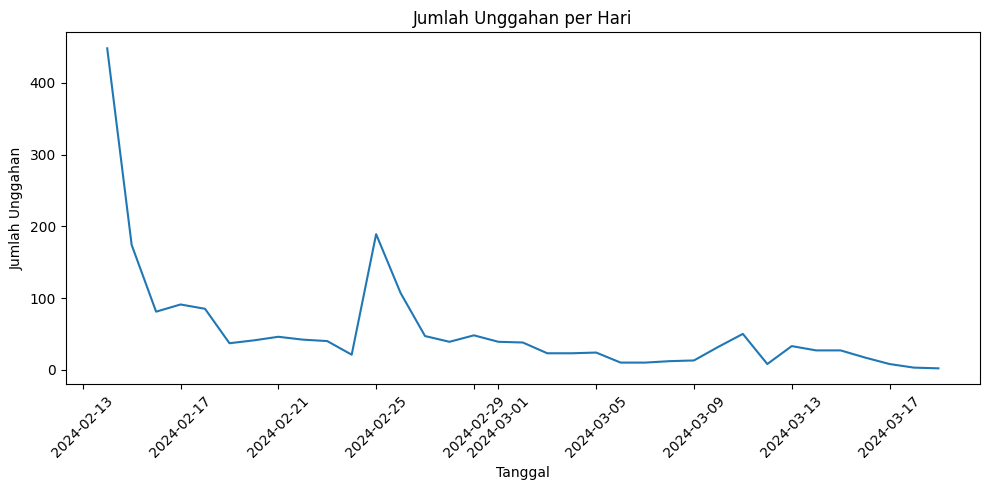

In [35]:
df['date'] = pd.to_datetime(df['date'])
df['date_only'] = df['date'].dt.date

tweet_per_day = df.groupby('date_only').size()

plt.figure(figsize=(10,5))
plt.plot(tweet_per_day.index, tweet_per_day.values)
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Unggahan')
plt.title('Jumlah Unggahan per Hari')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

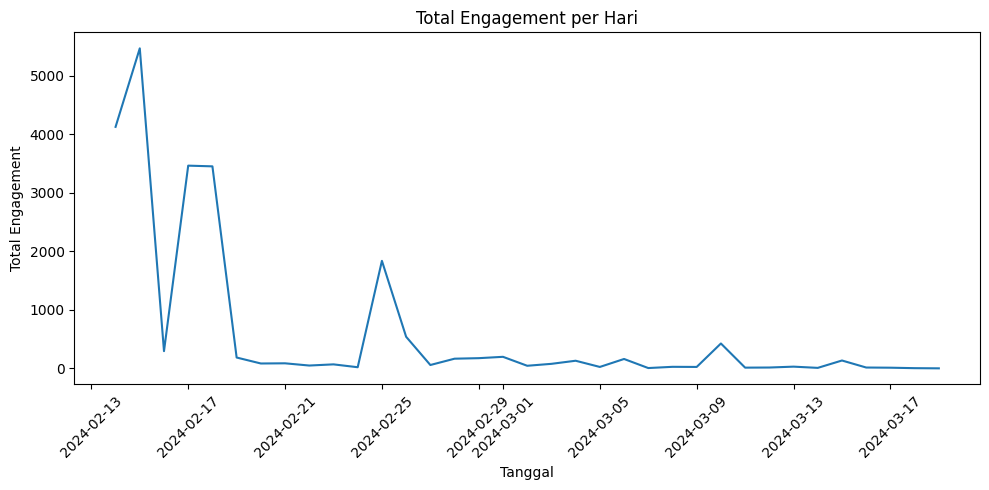

In [36]:
df['date'] = pd.to_datetime(df['date'])
df['date_only'] = df['date'].dt.date

engagement_per_day = df.groupby('date_only')['engagement'].sum()

plt.figure(figsize=(10,5))
plt.plot(engagement_per_day.index, engagement_per_day.values)
plt.xlabel('Tanggal')
plt.ylabel('Total Engagement')
plt.title('Total Engagement per Hari')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

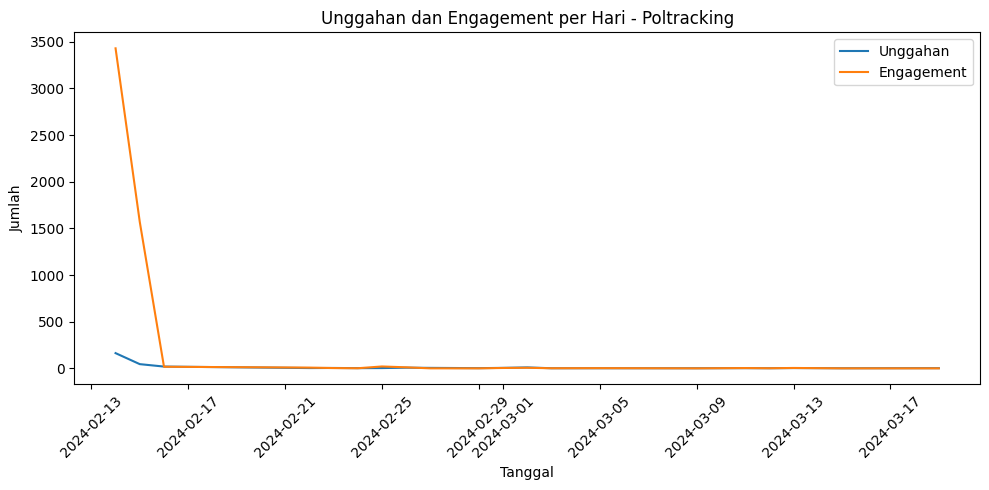

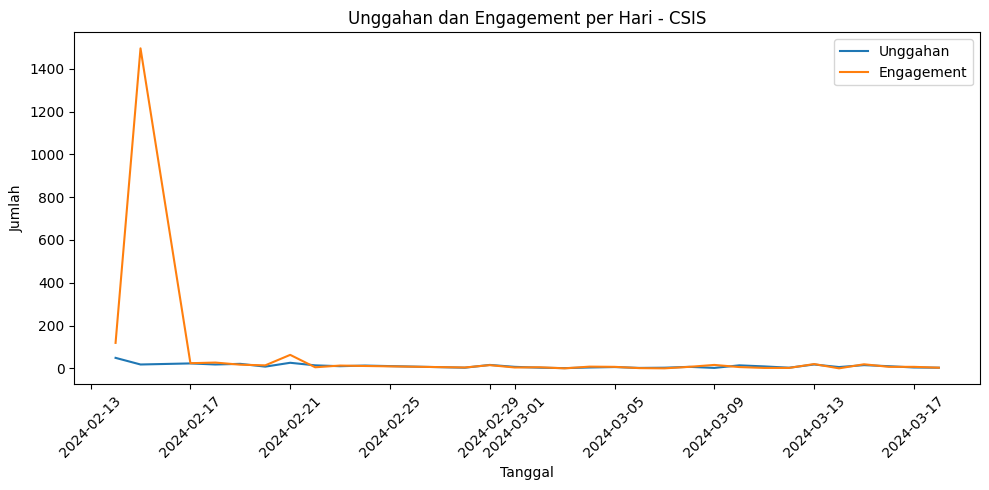

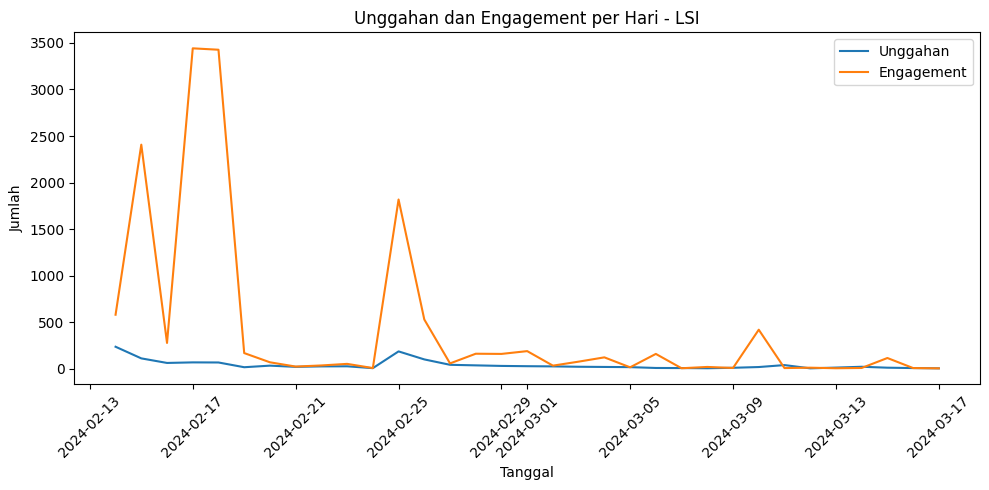

In [37]:
for lembaga in df['ls'].unique():
    data_lembaga = df[df['ls'] == lembaga]

    df['date'] = pd.to_datetime(df['date'])
    df['date_only'] = df['date'].dt.date

    tweet_day = data_lembaga.groupby('date_only').size()
    engagement_day = data_lembaga.groupby('date_only')['engagement'].sum()

    plt.figure(figsize=(10,5))
    plt.plot(tweet_day.index, tweet_day.values, label='Unggahan')
    plt.plot(engagement_day.index, engagement_day.values, label='Engagement')
    plt.title(f'Unggahan dan Engagement per Hari - {lembaga}')
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [38]:
# Ekstraksi Fitur TF-IDF
X = df['clean_text']
y = df['label']

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

X_tfidf.shape                     # (tweet, kata unik)

(1935, 4276)

In [40]:
# Tabel hasil TF-IDF
feature_names = tfidf.get_feature_names_out()

tfidf_df = pd.DataFrame(
    X_tfidf[:].toarray(),
    columns=feature_names
)

tfidf_df

1945  aamiin  aang  aas  abadi  abah  abai  abal  abalabal  abang  ...  \
0      0.0     0.0   0.0  0.0    0.0   0.0   0.0   0.0       0.0    0.0  ...   
1      0.0     0.0   0.0  0.0    0.0   0.0   0.0   0.0       0.0    0.0  ...   
2      0.0     0.0   0.0  0.0    0.0   0.0   0.0   0.0       0.0    0.0  ...   
3      0.0     0.0   0.0  0.0    0.0   0.0   0.0   0.0       0.0    0.0  ...   
4      0.0     0.0   0.0  0.0    0.0   0.0   0.0   0.0       0.0    0.0  ...   
...    ...     ...   ...  ...    ...   ...   ...   ...       ...    ...  ...   
1930   0.0     0.0   0.0  0.0    0.0   0.0   0.0   0.0       0.0    0.0  ...   
1931   0.0     0.0   0.0  0.0    0.0   0.0   0.0   0.0       0.0    0.0  ...   
1932   0.0     0.0   0.0  0.0    0.0   0.0   0.0   0.0       0.0    0.0  ...   
1933   0.0     0.0   0.0  0.0    0.0   0.0   0.0   0.0       0.0    0.0  ...   
1934   0.0     0.0   0.0  0.0    0.0   0.0   0.0   0.0       0.0    0.0  ...   

      yunarto  yuniarto  yusril  yusuf  zalim  zangum  zero  zionis  zona  \
0         0.0       0.0     0.0    0.0    0.0     0.0   0.0     0.0   0.0   
1         0.0       0.0     0.0    0.0    0.0     0.0   0.0     0.0   0.0   
2         0.0       0.0     0.0    0.0    0.0     0.0   0.0     0.0   0.0   
3         0.0       0.0     0.0    0.0    0.0     0.0   0.0     0.0   0.0   
4         0.0       0.0     0.0    0.0    0.0     0.0   0.0     0.0   0.0   
...       ...       ...     ...    ...    ...     ...   ...     ...   ...   
1930      0.0       0.0     0.0    0.0    0.0     0.0   0.0     0.0   0.0   
1931      0.0       0.0     0.0    0.0    0.0     0.0   0.0     0.0   0.0   
1932      0.0       0.0     0.0    0.0    0.0     0.0   0.0     0.0   0.0   
1933      0.0       0.0     0.0    0.0    0.0     0.0   0.0     0.0   0.0   
1934      0.0       0.0     0.0    0.0    0.0     0.0   0.0     0.0   0.0   

      zoom  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
...    ...  
1930   0.0  
1931   0.0  
1932   0.0  
1933   0.0  
1934   0.0  

[1935 rows x 4276 columns]

In [41]:
# Download data hasil tfidf
tfidf_df.to_excel('data_tfidf.xlsx', index=False)

from google.colab import files
files.download('data_tfidf.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
# TF-IDF Kata Penting (Rata-rata TF-IDF)
mean_tfidf = X_tfidf.mean(axis=0).A1
tfidf_scores = pd.DataFrame({
    'term': feature_names,
    'mean_tfidf': mean_tfidf
})

tfidf_scores.sort_values(by='mean_tfidf', ascending=False).head(20)

term  mean_tfidf
1484      indonesia    0.079448
3781         survei    0.076622
2112        lembaga    0.070628
734           count    0.046439
3163          quick    0.043499
777          daerah    0.040468
2938          pilih    0.040123
1556       istimewa    0.039003
1350          hasil    0.038939
1528  international    0.030622
4095           umum    0.028988
3072       presiden    0.026120
3020    poltracking    0.025992
3043        prabowo    0.025447
3732          suara    0.022835
649          center    0.022761
2810         partai    0.022397
162             and    0.021802
1119            for    0.021404
3727        studies    0.021341

In [43]:
#TF-IDF setiap Kelas atau Label
df_tfidf = pd.DataFrame(
    X_tfidf.toarray(),
    columns=feature_names
)

df_tfidf['label'] = y.values

df_tfidf.groupby('label').mean().T.sort_values(by='positif', ascending=False).head(10)

label       negatif    netral   positif
indonesia  0.078536  0.083158  0.078642
survei     0.075968  0.082508  0.074882
lembaga    0.077961  0.075864  0.064484
count      0.036320  0.042274  0.053816
hasil      0.027100  0.023550  0.051356
quick      0.035469  0.039912  0.049454
pilih      0.031043  0.030493  0.048863
presiden   0.014714  0.012098  0.037793
daerah     0.048580  0.035783  0.037444
istimewa   0.046303  0.033461  0.036759

In [44]:
# Splitting Data (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [45]:
# k-fold cross validation (k=10)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [46]:
# Mencari parameter terbaik
svm = OneVsRestClassifier(
    SVC(probability=True)
)

param_grid = {
    'estimator__kernel': ['rbf', 'linear', 'poly'],
    'estimator__C': [0.1, 1, 10],
    'estimator__gamma': ['scale', 'auto']
}

grid = GridSearchCV(
    svm,
    param_grid,
    cv=kf,
    scoring='f1_macro'
)

grid.fit(X_train, y_train)

grid.best_params_

{'estimator__C': 10,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'linear'}

In [47]:
grid.cv_results_

{'mean_fit_time': array([5.45516732, 4.58598094, 5.56150677, 3.72912323, 4.53216455,
        3.59646406, 5.66809039, 4.38317955, 5.69711616, 3.85262609,
        4.43924632, 3.55668435, 5.80388839, 5.35340829, 5.68783383,
        4.56915507, 5.30131385, 3.58910093]),
 'std_fit_time': array([0.26746915, 0.27416243, 0.27162271, 0.26116021, 0.24268539,
        0.25740308, 0.28968852, 0.24292056, 0.29708122, 0.25650825,
        0.27589139, 0.21823564, 0.34783108, 0.35216729, 0.31501571,
        0.2921479 , 0.31158473, 0.2641073 ]),
 'mean_score_time': array([0.1180269 , 0.10086136, 0.1254746 , 0.08506734, 0.09836709,
        0.08357971, 0.11494403, 0.09487417, 0.12689097, 0.08406465,
        0.09534128, 0.08344669, 0.10621188, 0.08139863, 0.11864867,
        0.09576602, 0.08465033, 0.08422785]),
 'std_score_time': array([0.0195187 , 0.009975  , 0.01679502, 0.01297162, 0.00965759,
        0.01056485, 0.01558346, 0.01386455, 0.01937106, 0.00991019,
        0.01460369, 0.00993483, 0.00169035, 

In [48]:
cv_results = pd.DataFrame(grid.cv_results_)

cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_estimator__C', 'param_estimator__gamma',
       'param_estimator__kernel', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [49]:
tabel_47 = cv_results[
    [
        'param_estimator__kernel',
        'param_estimator__C',
        'param_estimator__gamma',
        'mean_test_score',
        'std_test_score'
    ]
].copy()

tabel_47.columns = [
    'Kernel',
    'C',
    'gamma',
    'mean score',
    'stdev score'
]

# Urutkan
tabel_47 = tabel_47.sort_values(
    by='mean score',
    ascending=False
)

# Ambil 6 Teratas
tabel_47_top = tabel_47.head(6)

# Dibulatkan
tabel_47_top['mean score'] = tabel_47_top['mean score'].round(4)
tabel_47_top['stdev score'] = tabel_47_top['stdev score'].round(4)

tabel_47_top

/tmp/ipython-input-3838910993.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabel_47_top['mean score'] = tabel_47_top['mean score'].round(4)
/tmp/ipython-input-3838910993.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabel_47_top['stdev score'] = tabel_47_top['stdev score'].round(4)


Kernel     C  gamma  mean score  stdev score
13  linear  10.0  scale      0.5262       0.0383
16  linear  10.0   auto      0.5262       0.0383
12     rbf  10.0  scale      0.5148       0.0277
6      rbf   1.0  scale      0.4876       0.0368
10  linear   1.0   auto      0.4833       0.0268
7   linear   1.0  scale      0.4833       0.0268

In [50]:
tabel_47_top.to_excel('tabel_47_parameter_terbaik.xlsx', index=False)

In [51]:
# Pemodelan SVM Multiclass (OAA + linear)
svm_linear = OneVsRestClassifier(
    SVC(
        kernel='linear',
        C=10,
        probability=True,
        class_weight='balanced',
        random_state=42
    )
)

svm_linear.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=10, class_weight='balanced',
                                  kernel='linear', probability=True,
                                  random_state=42))

In [52]:
# Pemodelan SVM Multiclass (OAA + RBF)
svm_rbf = OneVsRestClassifier(
    SVC(
        kernel='rbf',
        C=10,
        gamma='scale',
        probability=True,
        class_weight='balanced',
        random_state=42
    )
)

svm_rbf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=10, class_weight='balanced',
                                  probability=True, random_state=42))

In [53]:
n_features_rbf = X_train.shape[1]
n_features_linear = X_train.shape[1]

n_support_rbf = [est.n_support_ for est in svm_rbf.estimators_]
n_support_linear = [est.n_support_ for est in svm_linear.estimators_]

tabel_48 = pd.DataFrame({
    'Hyperparameters': [
        'kernel rbf, C = 10',
        'kernel linear, C = 10'
    ],
    'n_features': [
        n_features_rbf,
        n_features_linear
    ],
    'n_support': [
        str(n_support_rbf),
        str(n_support_linear)
    ]
})

tabel_48

Hyperparameters  n_features  \
0     kernel rbf, C = 10        4276   
1  kernel linear, C = 10        4276   

                                           n_support  
0  [array([891, 445], dtype=int32), array([1035, ...  
1  [array([583, 362], dtype=int32), array([693, 2...

In [54]:
tabel_48.to_excel('Tabel_4_8_Deskripsi_Model.xlsx', index=False)

In [55]:
# Confusion Matrix RBF
y_pred_rbf = svm_rbf.predict(X_test)

cm_rbf = confusion_matrix(
    y_test,
    y_pred_rbf,
    labels=['positif', 'netral', 'negatif']
)

cm_rbf

array([[173,  12,  14],
       [ 47,  12,  13],
       [ 31,   9,  76]])

In [56]:
cm_rbf_df = pd.DataFrame(
    cm_rbf,
    index=['Aktual Positif', 'Aktual Netral', 'Aktual Negatif'],
    columns=['Pred Positif', 'Pred Netral', 'Pred Negatif']
)

cm_rbf_df

Pred Positif  Pred Netral  Pred Negatif
Aktual Positif           173           12            14
Aktual Netral             47           12            13
Aktual Negatif            31            9            76

In [57]:
# Confusion Matrix Linear
y_pred_linear = svm_linear.predict(X_test)

cm_linear = confusion_matrix(
    y_test,
    y_pred_linear,
    labels=['positif', 'netral', 'negatif']
)

cm_linear

array([[144,  33,  22],
       [ 39,  23,  10],
       [ 22,  23,  71]])

In [58]:
cm_linear_df = pd.DataFrame(
    cm_linear,
    index=['Aktual Positif', 'Aktual Netral', 'Aktual Negatif'],
    columns=['Pred Positif', 'Pred Netral', 'Pred Negatif']
)

cm_linear_df

Pred Positif  Pred Netral  Pred Negatif
Aktual Positif           144           33            22
Aktual Netral             39           23            10
Aktual Negatif            22           23            71

In [59]:
cm_rbf_df.to_excel('Confusion_Matrix_SVM_RBF.xlsx')
cm_linear_df.to_excel('Confusion_Matrix_SVM_Linear.xlsx')

In [60]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f'\n=== {name} ===')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

evaluate_model(svm_linear, X_test, y_test, 'SVM Linear')
evaluate_model(svm_rbf, X_test, y_test, 'SVM RBF')


=== SVM Linear ===
Accuracy: 0.6149870801033591
              precision    recall  f1-score   support

     negatif       0.69      0.61      0.65       116
      netral       0.29      0.32      0.30        72
     positif       0.70      0.72      0.71       199

    accuracy                           0.61       387
   macro avg       0.56      0.55      0.56       387
weighted avg       0.62      0.61      0.62       387


=== SVM RBF ===
Accuracy: 0.6744186046511628
              precision    recall  f1-score   support

     negatif       0.74      0.66      0.69       116
      netral       0.36      0.17      0.23        72
     positif       0.69      0.87      0.77       199

    accuracy                           0.67       387
   macro avg       0.60      0.56      0.56       387
weighted avg       0.64      0.67      0.65       387



In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1': f1_score(y_test, y_pred, average='macro')
    }

rbf_metrics = metrics(svm_rbf, X_test, y_test)
linear_metrics = metrics(svm_linear, X_test, y_test)

tabel_49 = pd.DataFrame([
    ['kernel rbf',
     f"{rbf_metrics['Accuracy']*100:.2f}%",
     f"{rbf_metrics['Precision']*100:.2f}%",
     f"{rbf_metrics['Recall']*100:.2f}%",
     f"{rbf_metrics['F1']*100:.2f}%"],

    ['kernel linear',
     f"{linear_metrics['Accuracy']*100:.2f}%",
     f"{linear_metrics['Precision']*100:.2f}%",
     f"{linear_metrics['Recall']*100:.2f}%",
     f"{linear_metrics['F1']*100:.2f}%"]
],
columns=['Model', 'Akurasi', 'Presisi', 'Recall', 'F1'])

tabel_49

Model Akurasi Presisi  Recall      F1
0     kernel rbf  67.44%  59.69%  56.37%  56.38%
1  kernel linear  61.50%  56.10%  55.17%  55.53%

In [62]:
tabel_49.to_excel('Tabel_4_9_Skor_Model.xlsx', index=False)